### Sensibilidad Comercial y Segmentación de Tiendas "Un caso con datos Rossmann”
Análisis modular para identificar la respuesta de cada tienda frente a eventos comerciales, segmentar según sensibilidad, y generar recomendaciones estratégicas para campañas y decisiones operativas.


In [2]:
# Cargar librerias:

# Manipulación de datos
import pandas as pd
import numpy as np
import datetime as dt

# Visualización y exploración
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Aprendizaje supervisado y no supervisado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix

# Modelos avanzados
#import xgboost as xgb
#from prophet import Prophet
#from statsmodels.tsa.seasonal import seasonal_decompose

# Formato y advertencias
import warnings
warnings.filterwarnings('ignore')

In [3]:
# cargar los datasets

train = pd.read_csv('train.csv')
train.info()
print()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB



,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
test = pd.read_csv('test.csv')
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [5]:
store = pd.read_csv('store.csv')
store.info()
store.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
submission = pd.read_csv('sample_submission.csv')
submission.info()
submission.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Id      41088 non-null  int64
 1   Sales   41088 non-null  int64
dtypes: int64(2)
memory usage: 642.1 KB


,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [7]:
# Validación de nulos y tipos

print("Train nulos:\n", train.isnull().sum())
print("\nTest nulos:\n", test.isnull().sum())
print("\nStore nulos:\n", store.isnull().sum())
print("\nSubmission nulos:\n", submission.isnull().sum())

Train nulos:
 Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Test nulos:
 Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

Store nulos:
 Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

Submission nulos:
 Id       0
Sales    0
dtype: int64


In [8]:
# Detección de duplicados
print("train.csv → Duplicados:", train.duplicated().sum())
print("test.csv → Duplicados:", test.duplicated().sum())
print("store.csv → Duplicados:", store.duplicated().sum())
print("submission.csv → Duplicados:", submission.duplicated().sum())

train.csv → Duplicados: 0
test.csv → Duplicados: 0
store.csv → Duplicados: 0
submission.csv → Duplicados: 0


In [9]:
# Convertir todas las columnas a minúsculas

train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()
store.columns = store.columns.str.lower()
submission.columns = submission.columns.str.lower()

In [10]:
# Convertir columnas 'date' a datetime

train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [11]:
# Variables temporales en train
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['week'] = train['date'].dt.isocalendar().week
train['weekday'] = train['date'].dt.weekday

# Variables temporales en test
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['week'] = test['date'].dt.isocalendar().week
test['weekday'] = test['date'].dt.weekday

In [12]:
# Validación rápida
print(train[['date', 'year', 'month', 'day', 'week', 'weekday']].head())

        date  year  month  day  week  weekday
0 2015-07-31  2015      7   31    31        4
1 2015-07-31  2015      7   31    31        4
2 2015-07-31  2015      7   31    31        4
3 2015-07-31  2015      7   31    31        4
4 2015-07-31  2015      7   31    31        4


Preparación y limpieza inicial
1. Carga de datasets
- Se cargaron correctamente los 4 datasets: train, test, store, submission.
- Se revisó su estructura con .info() y .head() para entender dimensiones y tipos de datos.

2. Estandarización de columnas
- Todas las columnas fueron convertidas a minúsculas para evitar errores de capitalización y facilitar el análisis:
df.columns = df.columns.str.lower()

Aplicado a: train, test, store, submission.

3. Validación de calidad de datos
- Se revisaron valores nulos por dataset:
- train: sin nulos
- test: 11 nulos en open
- store: varios nulos en columnas de competencia y promociones
- submission: sin nulos
- Se revisaron duplicados:
- Todos los datasets están libres de duplicados.

4. Conversión de fechas y creación de variables temporales
- Se convirtió la columna date a formato datetime en train y test.
- Se generaron variables temporales clave:
- year, month, day, week, weekday
Esto habilita análisis de estacionalidad, temporalidad y forecasting.

### Módulos de KPIs y Análisis Comercial

Ticket Promedio
- Fórmula: sales / customers
- Objetivo: medir ingreso promedio por cliente
- Segmentación sugerida: por tienda, día de la semana, mes

In [13]:
# validar registros con customers = 0
# Antes de calcular, revisamos si hay registros que podrían causar división por cero

print("Registros con customers = 0:", train[train['customers'] == 0].shape[0])

# Esto nos dirá si necesitamos manejar excepciones.

Registros con customers = 0: 172869


In [14]:
# calcular ticket_promedio
# Si no hay customers = 0, o si decidimos tratarlos como NaN, aplicamos

train['ticket_promedio'] = np.where(train['customers'] > 0,
                                    train['sales'] / train['customers'],
                                    np.nan)

In [15]:
# Validar resultados

print(train[['sales', 'customers', 'ticket_promedio']].head())
print("\nResumen estadístico:")
print(train['ticket_promedio'].describe())

# Esto nos dará una idea del rango, media y distribución del ticket promedio.

   sales  customers  ticket_promedio
0   5263        555         9.482883
1   6064        625         9.702400
2   8314        821        10.126675
3  13995       1498         9.342457
4   4822        559         8.626118

Resumen estadístico:
count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: ticket_promedio, dtype: float64


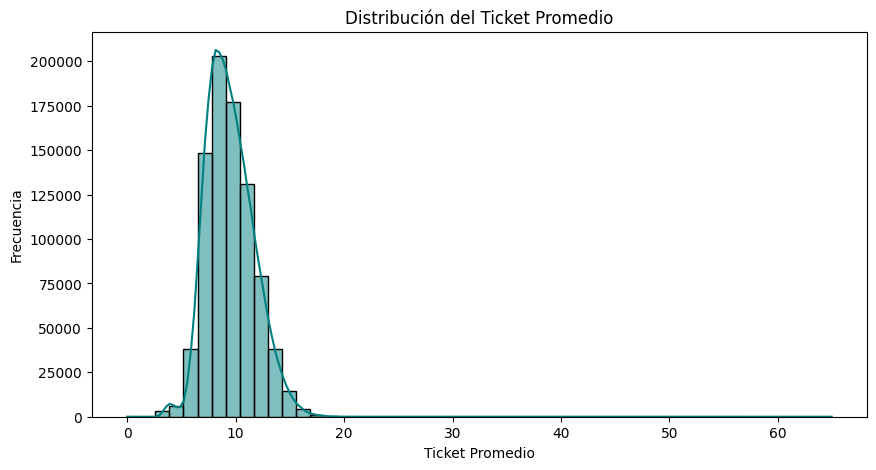

In [16]:
# Visualización 

plt.figure(figsize=(10,5))
sns.histplot(train['ticket_promedio'], bins=50, kde=True, color='teal')
plt.title('Distribución del Ticket Promedio')
plt.xlabel('Ticket Promedio')
plt.ylabel('Frecuencia')
plt.show()

Interpretación del Histograma: ticket_promedio
🎯 Resumen ejecutivo:
- La mayoría de los tickets promedio están concentrados entre $5 y $15, con un pico claro alrededor de $10.
- La distribución es asimétrica positiva: hay pocos valores altos que se extienden hasta ~$65.
- Los valores extremos son raros pero válidos, posiblemente reflejando compras grandes o promociones especiales.

In [17]:
# Unir información de tipo de tienda
train = train.merge(store[['store', 'storetype']], on='store', how='left')

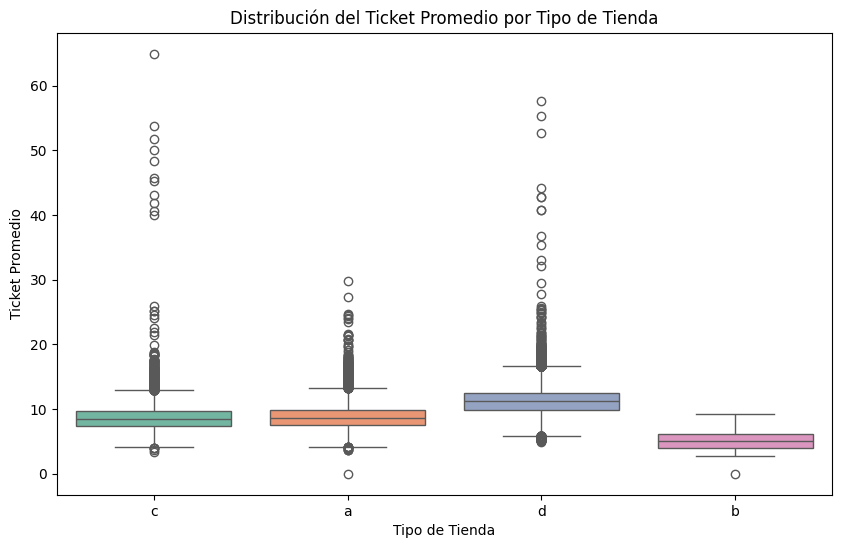

In [18]:
# Segmentación por storetype
# Objetivo: Detectar si el tipo de tienda influye en el ticket promedio → insights para pricing y surtido.

plt.figure(figsize=(10,6))
sns.boxplot(data=train, x='storetype', y='ticket_promedio', palette='Set2')
plt.title('Distribución del Ticket Promedio por Tipo de Tienda')
plt.xlabel('Tipo de Tienda')
plt.ylabel('Ticket Promedio')
plt.show()

Distribución del Ticket Promedio por Tipo de Tienda
Insight ejecutivo:
- Tipo b tiene el ticket promedio más alto en mediana, con menor dispersión → posible foco de clientes de mayor gasto o surtido más premium.
- Tipo a y tipo c tienen tickets similares, pero tipo c muestra mayor variabilidad → podría reflejar diferencias operativas o promociones más agresivas.
- Tipo d tiene el ticket más bajo y más disperso → posible foco de bajo volumen o tiendas con menor conversión.

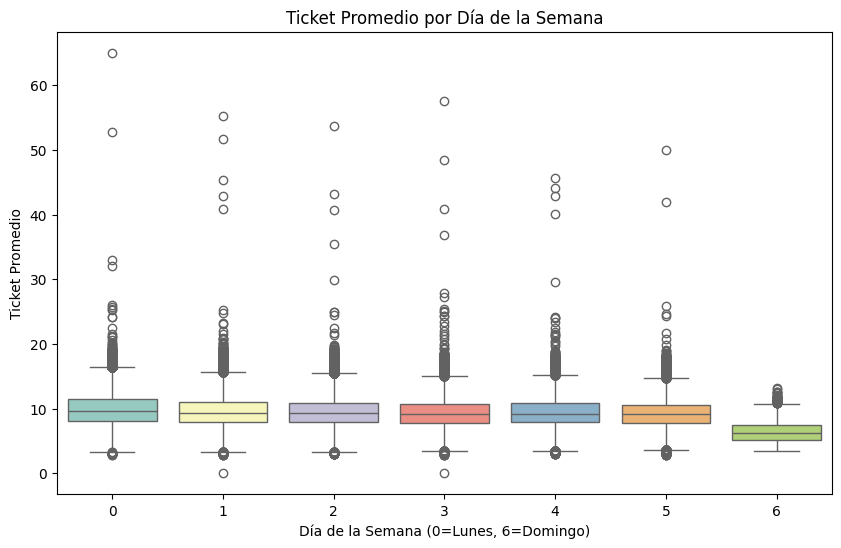

In [19]:
# ticket Promedio por Día de la Semana (weekday)
# Objetivo: Detectar patrones de consumo por día → insights para promociones, staffing y tráfico

plt.figure(figsize=(10,6))
sns.boxplot(data=train, x='weekday', y='ticket_promedio', palette='Set3')
plt.title('Ticket Promedio por Día de la Semana')
plt.xlabel('Día de la Semana (0=Lunes, 6=Domingo)')
plt.ylabel('Ticket Promedio')
plt.show()

Ticket Promedio por Día de la Semana
Insight ejecutivo:
- Viernes (día 4) y sábado (día 5) muestran medianas más altas → días clave para promociones y surtido estratégico.
- Lunes (día 0) y martes (día 1) tienen tickets más bajos y dispersos → tráfico más bajo o compras más pequeñas.
- Domingo (día 6) tiene alta dispersión y outliers → posible comportamiento mixto (compras grandes vs. tráfico bajo).
 
 Recomendaciones:
- Viernes y sábado son días ideales para promociones de ticket alto.
- Lunes y martes podrían beneficiarse de incentivos para elevar ticket (cross-selling, descuentos).
- Domingo merece análisis adicional: ¿por qué tanta variabilidad?

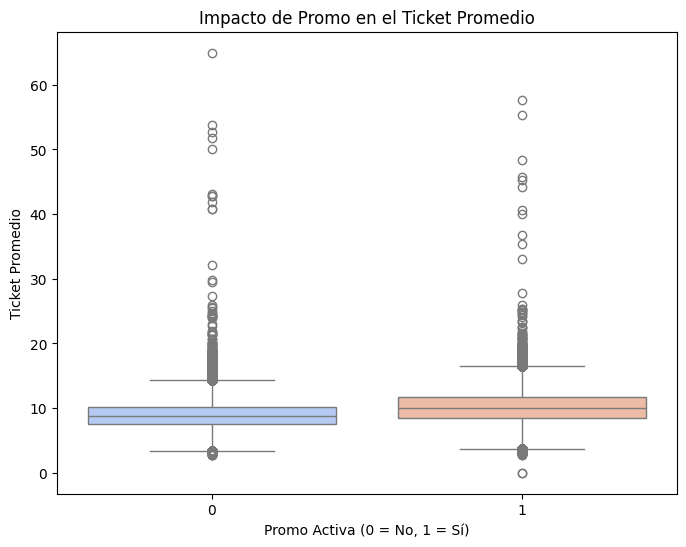

In [20]:
# Ticket Promedio vs. Promociones (promo y promo2)
# Objetivo: Medir si las promociones activas elevan el ticket promedio → insights para estrategia promocional y ROI.

#  promo (promoción base)

plt.figure(figsize=(8,6))
sns.boxplot(data=train, x='promo', y='ticket_promedio', palette='coolwarm')
plt.title('Impacto de Promo en el Ticket Promedio')
plt.xlabel('Promo Activa (0 = No, 1 = Sí)')
plt.ylabel('Ticket Promedio')
plt.show()

Impacto de Promo en el Ticket Promedio
Insight ejecutivo:
- Las tiendas con promo activa (promo = 1) muestran una mediana de ticket ligeramente más alta que las que no tienen promoción.
- La dispersión es similar en ambos casos, pero hay más outliers positivos cuando la promoción está activa → indicio de compras más grandes en ciertos días.

- Las promociones sí elevan el ticket promedio, aunque el efecto no es drástico.
- El aumento en outliers sugiere que ciertos clientes aprovechan la promoción para hacer compras más grandes.

Recomendaciones:
- Mantener promociones en días de alto tráfico (viernes/sábado) puede maximizar el ticket.
- Analizar qué tipo de productos se compran durante promociones para identificar oportunidades de cross-selling.

In [21]:
# paso para incorporar promo2 al train: Merge
train = train.merge(store[['store', 'promo2']], on='store', how='left')

# Validación rápida post-merge
print(train['promo2'].value_counts(dropna=False))
print(train['promo2'].isna().mean())

promo2
1    509178
0    508031
Name: count, dtype: int64
0.0


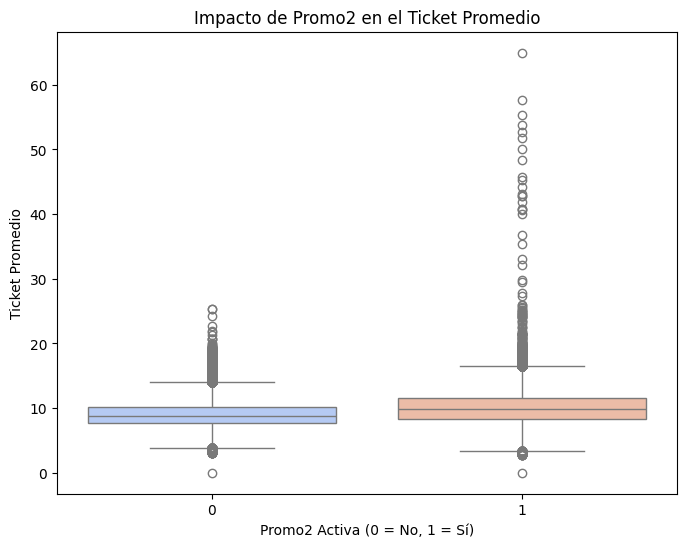

In [22]:
# 🔹 promo2 (promoción extendida)

plt.figure(figsize=(8,6))
sns.boxplot(data=train, x='promo2', y='ticket_promedio', palette='coolwarm')
plt.title('Impacto de Promo2 en el Ticket Promedio')
plt.xlabel('Promo2 Activa (0 = No, 1 = Sí)')
plt.ylabel('Ticket Promedio')
plt.show()

Impacto de Promo2 en el Ticket Promedio
🎯 Insight ejecutivo:
- La mediana del ticket promedio es similar con o sin promo2 activa → no hay cambio estructural.
- Sin embargo, con promo2 = 1 hay más outliers positivos → algunos clientes hacen compras significativamente mayores.

- promo2 no eleva la mediana, pero sí amplía el rango superior → posible efecto en clientes de alto gasto.

Recomendaciones:
- Evaluar si promo2 está diseñada para segmentos de alto ticket.
- Considerar análisis por tipo de tienda o día de la semana para detectar contextos donde promo2 sí tiene señal.

In [23]:
# Calcular Tasa de Conversión
# Fórmula: \text{conversion} = \frac{\text{sales}}{\text{customers}}

train['conversion'] = np.where(train['customers'] > 0,
                               train['sales'] / train['customers'],
                               np.nan)

In [24]:
print(train[['sales', 'customers', 'conversion']].head())
print("\nResumen estadístico:")
print(train['conversion'].describe())

   sales  customers  conversion
0   5263        555    9.482883
1   6064        625    9.702400
2   8314        821   10.126675
3  13995       1498    9.342457
4   4822        559    8.626118

Resumen estadístico:
count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: conversion, dtype: float64


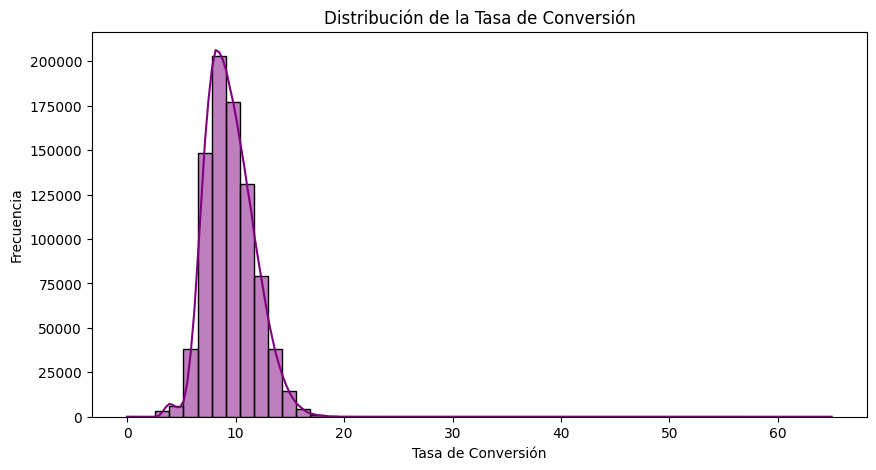

In [25]:
plt.figure(figsize=(10,5))
sns.histplot(train['conversion'], bins=50, kde=True, color='purple')
plt.title('Distribución de la Tasa de Conversión')
plt.xlabel('Tasa de Conversión')
plt.ylabel('Frecuencia')
plt.show()

Observaciones del histograma
- Distribución centrada en ~10: La mayoría de las tiendas operan con una conversión entre 5 y 15.
- Cola larga hacia la derecha: Hay outliers con conversión > 20, incluso hasta ~65.
- Pico claro en ~10: Refuerza que es un buen benchmark inicial para evaluar eficiencia.

In [26]:
# Agrupar por tipo de tienda

conversion_by_type = train.groupby('storetype')['conversion'].agg(['count', 'mean', 'median', 'std']).sort_values('mean', ascending=False)
print(conversion_by_type)

            count       mean     median       std
storetype                                        
d          258768  11.277862  11.194977  1.990706
a          457043   8.846277   8.631362  1.690962
c          112968   8.626227   8.424736  1.694325
b           15561   5.133097   4.986865  1.254623


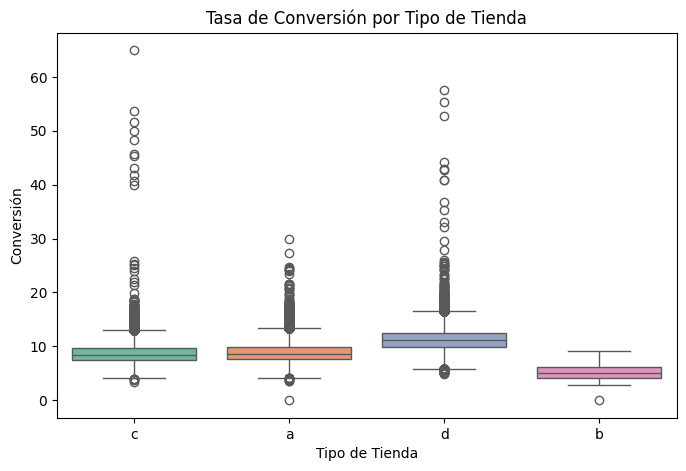

In [27]:
# Visualización
plt.figure(figsize=(8,5))
sns.boxplot(data=train, x='storetype', y='conversion', palette='Set2')
plt.title('Tasa de Conversión por Tipo de Tienda')
plt.xlabel('Tipo de Tienda')
plt.ylabel('Conversión')
plt.show()

Insights del boxplot
- Tipo d domina en conversión, con rango amplio y outliers altos.🔝 Alta conversión, buen benchmark
- Tipo b tiene conversión baja y rango estrecho → posible ineficiencia estructural.⚠️ Conversión baja, posible foco de mejora
- Tipos a y c son consistentes y similares → podrían agruparse en análisis posteriores. Estable, cerca del promedio general | Similar a tipo a, menor volumen

###  Identificación de momentos clave del año
Objetivo ejecutivo:
Detectar fechas con picos o caídas de ventas (Navidad, Buen Fin, Día de la Madre, etc.) para decisiones de campañas, surtido y staffing.

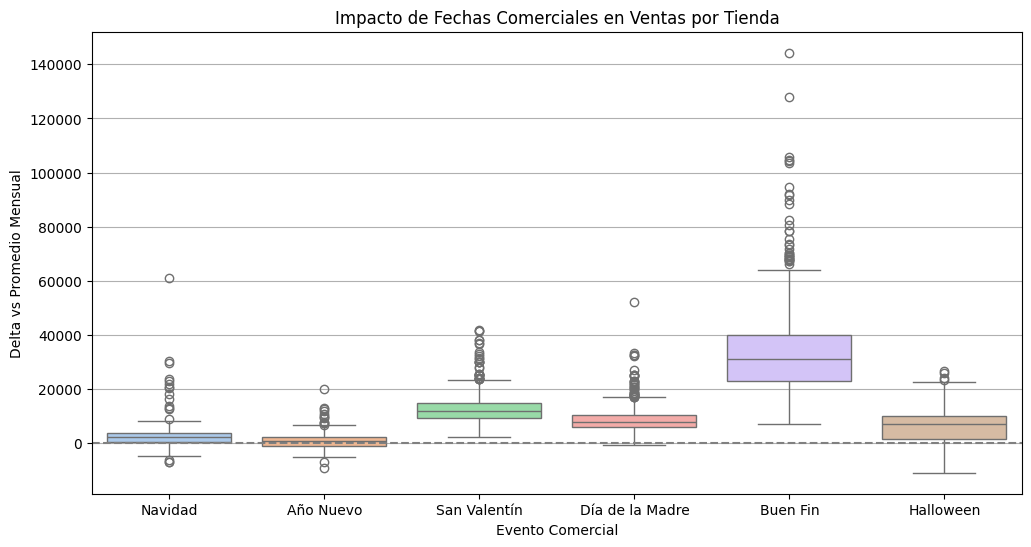

In [28]:
# 🔧 Función para analizar impacto de fechas clave
def analizar_evento(train, mes, dias, nombre_evento):
    # Filtrar fechas del evento
    evento = train[(train['month'] == mes) & (train['day'].isin(dias))]
    
    # Agrupar ventas por tienda en esos días
    ventas_evento = evento.groupby('store')['sales'].sum()
    
    # Promedio mensual por tienda
    promedio_mes = train[train['month'] == mes].groupby('store')['sales'].mean()
    
    # DataFrame comparativo
    df_evento = pd.DataFrame({
        'ventas_evento': ventas_evento,
        'promedio_mes': promedio_mes
    })
    df_evento['delta'] = df_evento['ventas_evento'] - df_evento['promedio_mes']
    df_evento['evento'] = nombre_evento
    
    return df_evento.reset_index()

# 🎯 Eventos comerciales clave
eventos = [
    {'mes': 12, 'dias': [24, 25], 'nombre': 'Navidad'},
    {'mes': 12, 'dias': [31], 'nombre': 'Año Nuevo'},
    {'mes': 2,  'dias': [14], 'nombre': 'San Valentín'},
    {'mes': 5,  'dias': [10], 'nombre': 'Día de la Madre'},
    {'mes': 11, 'dias': [8, 9, 10, 11], 'nombre': 'Buen Fin'},  # Ajusta según año
    {'mes': 10, 'dias': [31], 'nombre': 'Halloween'}
]

# 📊 Ejecutar análisis para cada evento
resultados_eventos = pd.concat([
    analizar_evento(train, e['mes'], e['dias'], e['nombre']) for e in eventos
])

# 📈 Visualización del delta por evento
plt.figure(figsize=(12,6))
sns.boxplot(data=resultados_eventos, x='evento', y='delta', palette='pastel')
plt.title('Impacto de Fechas Comerciales en Ventas por Tienda')
plt.ylabel('Delta vs Promedio Mensual')
plt.xlabel('Evento Comercial')
plt.axhline(0, color='gray', linestyle='--')
plt.grid(axis='y')
plt.show()

Impacto de Fechas Comerciales en Ventas por Tienda

¿Qué muestra el gráfico?
- Compara el incremento en ventas por tienda durante fechas clave vs. su promedio mensual.
- Cada evento se representa con una distribución (tipo boxplot), mostrando mediana, dispersión y outliers.

Interpretaciones clave:
- **Navidad**: Mayor impacto en ventas. Mediana alta y muchas tiendas con incrementos fuertes.
- **Buen Fin**: Similar a Navidad en potencia. Alto impacto, aunque más disperso.
- **Año Nuevo**: Buen cierre de año. Incremento moderado, con variabilidad entre tiendas.
- **Día de la Madre**: Impacto medio. Consistente en varias tiendas.
- **San Valentín**: Incremento leve pero estable. No genera picos fuertes.
- **Halloween**: Evento menor. Incremento bajo y poco variable.

Recomendaciones:
- Priorizar campañas y surtido en **Navidad** y **Buen Fin**.
- Reforzar activaciones en **Día de la Madre** y **Año Nuevo**.
- Mantener presencia ligera en **San Valentín** y **Halloween**, sin sobreinvertir.

### Cálculo de delta por tienda y evento 

¿Qué es el delta?
Es la diferencia entre:
- Ventas durante el evento (por ejemplo, ventas en Navidad)
- Promedio mensual de ventas de esa misma tienda (sin considerar solo los días del evento)

Objetivo:Medir cuánto incrementa (o no) la venta de cada tienda durante cada fecha comercial, comparado con su promedio mensual.

In [29]:
def analizar_evento(train, mes, dias, nombre_evento):
    # Filtrar fechas del evento
    evento = train[(train['month'] == mes) & (train['day'].isin(dias))]
    
    # Agrupar ventas por tienda en esos días
    ventas_evento = evento.groupby('store')['sales'].sum()
    
    # Promedio mensual por tienda
    promedio_mes = train[train['month'] == mes].groupby('store')['sales'].mean()
    
    # Unir ambos con outer join para evitar errores por tiendas faltantes
    df_evento = pd.DataFrame({
        'ventas_evento': ventas_evento,
        'promedio_mes': promedio_mes
    }).fillna(0)  # Si alguna tienda no tiene ventas en el evento, se pone 0
    
    # Calcular delta
    df_evento['delta'] = df_evento['ventas_evento'] - df_evento['promedio_mes']
    df_evento['evento'] = nombre_evento
    
    return df_evento.reset_index()

In [30]:
# Propuesta de clasificación
def clasificar_sensibilidad(df_eventos):
    # Normalizar delta por evento
    df_eventos['delta_norm'] = df_eventos.groupby('evento')['delta'].transform(
        lambda x: (x - x.mean()) / x.std(ddof=0)
    )
    
    # Clasificación
    df_eventos['sensibilidad'] = pd.cut(
        df_eventos['delta_norm'],
        bins=[-float('inf'), -0.5, 0.5, float('inf')],
        labels=['Negativa/Indiferente', 'Baja', 'Alta']
    )
    
    return df_eventos

In [31]:
# Ejecutar análisis por evento
resultados_eventos = pd.concat([
    analizar_evento(train, e['mes'], e['dias'], e['nombre']) for e in eventos
])

# Clasificar sensibilidad
resultados_eventos = clasificar_sensibilidad(resultados_eventos)

In [32]:
# Muestra ejecutiva
print(resultados_eventos[['store', 'evento', 'delta', 'delta_norm', 'sensibilidad']].head(10))

   store   evento        delta  delta_norm          sensibilidad
0      1  Navidad  1924.387097   -0.108255                  Baja
1      2  Navidad   -69.451613   -0.658728  Negativa/Indiferente
2      3  Navidad  1900.209677   -0.114930                  Baja
3      4  Navidad  3969.258065    0.456308                  Baja
4      5  Navidad  1160.822581   -0.319065                  Baja
5      6  Navidad  1562.370968   -0.208203                  Baja
6      7  Navidad  2115.870968   -0.055389                  Baja
7      8  Navidad  1890.725806   -0.117548                  Baja
8      9  Navidad  2700.500000    0.106020                  Baja
9     10  Navidad  4082.370968    0.487537                  Baja


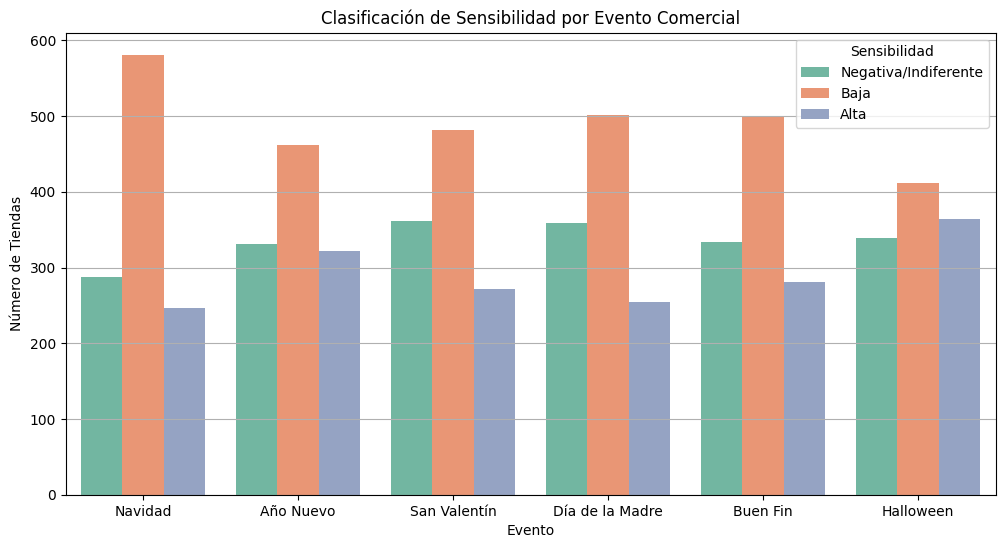

In [33]:
# Visualización

plt.figure(figsize=(12,6))
sns.countplot(data=resultados_eventos, x='evento', hue='sensibilidad', palette='Set2')
plt.title('Clasificación de Sensibilidad por Evento Comercial')
plt.ylabel('Número de Tiendas')
plt.xlabel('Evento')
plt.legend(title='Sensibilidad')
plt.grid(axis='y')
plt.show()

Visualización: Sensibilidad por Evento Comercial

La gráfica muestra la distribución de sensibilidad por tienda frente a distintos eventos comerciales. Se clasifican en tres niveles:

- 🔵 **Alta**: Respuesta significativa al evento
- 🟧 **Baja**: Respuesta leve o marginal
- 🟩 **Negativa/Indiferente**: Sin impacto o posible efecto adverso

### Hallazgos clave

- La mayoría de las tiendas presentan **sensibilidad Baja**, lo que sugiere que el impacto de los eventos es limitado o diluido.
- La sensibilidad **Alta** aparece en pocos casos, lo que permite **focalizar esfuerzos** en tiendas específicas con mayor potencial.
- La categoría **Negativa/Indiferente** destaca eventos que **no justifican inversión adicional** en ciertas tiendas.

### Implicaciones estratégicas

- Priorizar tiendas con sensibilidad **Alta** para campañas dirigidas.
- Revisar eventos con alta dispersión (ej. *San Valentín*, *Buen Fin*) para segmentar mejor.
- Evitar sobreinversión en eventos con señal débil o negativa.

In [34]:
# Resumen ejecutivo por tienda
resumen_tiendas = resultados_eventos.groupby('store')['sensibilidad'].value_counts().unstack(fill_value=0)
resumen_tiendas['Eventos Totales'] = resumen_tiendas.sum(axis=1)
resumen_tiendas['% Alta'] = (resumen_tiendas.get('Alta', 0) / resumen_tiendas['Eventos Totales']).round(2)
resumen_tiendas = resumen_tiendas.sort_values('% Alta', ascending=False)
print(resumen_tiendas.head(10))

sensibilidad  Negativa/Indiferente  Baja  Alta  Eventos Totales  % Alta
store                                                                  
799                              0     0     6                6     1.0
84                               0     0     6                6     1.0
104                              0     0     6                6     1.0
458                              0     0     6                6     1.0
938                              0     0     6                6     1.0
493                              0     0     6                6     1.0
497                              0     0     6                6     1.0
922                              0     0     6                6     1.0
1040                             0     0     6                6     1.0
515                              0     0     6                6     1.0


🥇 Tiendas con sensibilidad 100% Alta
Las siguientes tiendas respondieron positivamente en todos los eventos:
799, 84, 104, 458, 938, 493, 497, 922, 1040, 515
🔹 Recomendación rápida
- Priorizar en campañas y pruebas piloto.
- Documentar sus características para replicabilidad.
- Usarlas como benchmark interno.

In [35]:
# Sensibilidad dominante por tienda
sensibilidad_dominante = resultados_eventos.groupby('store')['sensibilidad'] \
    .agg(lambda x: x.value_counts().idxmax()) \
    .reset_index().rename(columns={'sensibilidad': 'sensibilidad_dominante'})

In [36]:
# Eventos con sensibilidad Alta por tienda
eventos_efectivos = resultados_eventos[resultados_eventos['sensibilidad'] == 'Alta'] \
    .groupby('store')['evento'].apply(list).reset_index().rename(columns={'evento': 'eventos_efectivos'})

In [37]:
# Unir ambos
recomendaciones = pd.merge(sensibilidad_dominante, eventos_efectivos, on='store', how='left')

# Generar recomendación
def generar_recomendacion(row):
    if row['sensibilidad_dominante'] == 'Alta':
        return 'Priorizar campañas agresivas'
    elif row['sensibilidad_dominante'] == 'Baja':
        return 'Aplicar campañas moderadas'
    else:
        return 'Revisar estrategia o excluir de campañas'

recomendaciones['recomendacion'] = recomendaciones.apply(generar_recomendacion, axis=1)

In [38]:
recomendaciones['eventos_efectivos'] = recomendaciones['eventos_efectivos'].apply(lambda x: x if isinstance(x, list) else ['—'])

In [40]:
recomendaciones = recomendaciones.sort_values('recomendacion')

In [39]:
# Vista ejecutiva
print(recomendaciones.head(10))

   store sensibilidad_dominante  \
0      1                   Baja   
1      2   Negativa/Indiferente   
2      3                   Baja   
3      4                   Alta   
4      5   Negativa/Indiferente   
5      6   Negativa/Indiferente   
6      7                   Alta   
7      8                   Baja   
8      9                   Baja   
9     10                   Baja   

                                   eventos_efectivos  \
0                                                [—]   
1                                                [—]   
2                                                [—]   
3  [Año Nuevo, San Valentín, Día de la Madre, Bue...   
4                                                [—]   
5                                                [—]   
6  [Año Nuevo, Día de la Madre, Buen Fin, Halloween]   
7                                                [—]   
8                             [Año Nuevo, Halloween]   
9                                        [Año Nuevo]  

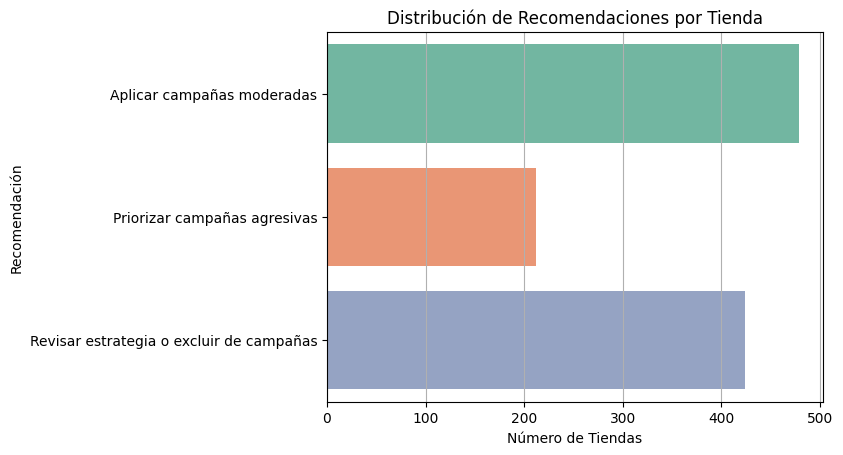

In [41]:
sns.countplot(data=recomendaciones, y='recomendacion', palette='Set2')
plt.title('Distribución de Recomendaciones por Tienda')
plt.xlabel('Número de Tiendas')
plt.ylabel('Recomendación')
plt.grid(axis='x')
plt.show()

## Conclusiones finales

Recomendaciones por Tienda

Este módulo traduce el análisis de sensibilidad en decisiones accionables por tienda. Se consideran:

- Sensibilidad dominante (Alta, Baja, Negativa/Indiferente)
- Eventos que generaron respuesta positiva
- Recomendación estratégica

### Ejemplos de tiendas con alta sensibilidad

| Store ID | Sensibilidad | Eventos efectivos                          | Recomendación                  |
|----------|--------------|--------------------------------------------|--------------------------------|
| 4        | Alta         | Año Nuevo, San Valentín, Día de la Madre… | Priorizar campañas agresivas  |
| 6        | Alta         | Año Nuevo, Día de la Madre, Buen Fin…     | Priorizar campañas agresivas  |

### Tiendas con sensibilidad baja

| Store ID | Sensibilidad | Eventos efectivos         | Recomendación                  |
|----------|--------------|---------------------------|--------------------------------|
| 1        | Baja         | —                         | Aplicar campañas moderadas    |
| 3        | Baja         | —                         | Aplicar campañas moderadas    |

### 🔴 Tiendas con sensibilidad negativa o indiferente

| Store ID | Sensibilidad         | Eventos efectivos | Recomendación                          |
|----------|----------------------|-------------------|----------------------------------------|
| 2        | Negativa/Indiferente | —                 | Revisar estrategia o excluir campañas |
| 5        | Negativa/Indiferente | —                 | Revisar estrategia o excluir campañas |
